# DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.11.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [5]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.5241856479297082 -2.4869053002172326
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [204]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, rates, training

In [205]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [206]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [219]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates, training):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, training=training)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, training=training)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, training=training, 
                        reuse=True) # Qs
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    return actions_logits, gQs, gloss, dloss

In [220]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [221]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates, self.training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            rates=self.rates, training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

In [222]:
def sample(buffer, batch_size):
    idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
    return np.array([buffer[ii] for ii in idx])

In [223]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [224]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [225]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [226]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [227]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1 # [-1, +1] or [0, 1]
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500 # [0, 1]
        total_reward = 0
        for idx in range(num_step):
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        num_step = 0

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [228]:
#batch = memory.buffer
def minibatch(batch):
    rates = np.array([each[-1] for each in batch])
    ##############################
    states = np.array([each[0] for each in batch])[rates > 0]
    actions = np.array([each[1] for each in batch])[rates > 0]
    next_states = np.array([each[2] for each in batch])[rates > 0]
    rewards = np.array([each[3] for each in batch])[rates > 0]
    dones = np.array([each[4] for each in batch])[rates > 0]
    rates = np.array([each[5] for each in batch])[rates > 0]
    ##########################################
    maxpercentage = 0.6
    maxstates = states[rates > (max(rates)*maxpercentage)]
    maxactions = actions[rates > (max(rates)*maxpercentage)]
    maxnext_states = next_states[rates > (max(rates)*maxpercentage)]
    maxrewards = rewards[rates > (max(rates)*maxpercentage)]
    maxdones = dones[rates > (max(rates)*maxpercentage)]
    maxrates = rates[rates > (max(rates)*maxpercentage)]
    ##################################################
    minpercentage = 0.4
    minstates = states[rates < (max(rates)*minpercentage)]
    minactions = actions[rates < (max(rates)*minpercentage)]
    minnext_states = next_states[rates < (max(rates)*minpercentage)]
    minrewards = rewards[rates < (max(rates)*minpercentage)]
    mindones = dones[rates < (max(rates)*minpercentage)]
    minrates = rates[rates < (max(rates)*minpercentage)]
    #################################################
    maxstates = sample(batch_size=batch_size, buffer=maxstates)
    minstates = sample(batch_size=batch_size, buffer=minstates)
    maxactions = sample(batch_size=batch_size, buffer=maxactions)
    minactions = sample(batch_size=batch_size, buffer=minactions)
    maxnext_states = sample(batch_size=batch_size, buffer=maxnext_states)
    minnext_states = sample(batch_size=batch_size, buffer=minnext_states)
    maxrewards = sample(batch_size=batch_size, buffer=maxrewards)
    minrewards = sample(batch_size=batch_size, buffer=minrewards)
    maxdones = sample(batch_size=batch_size, buffer=maxdones)
    mindones = sample(batch_size=batch_size, buffer=mindones)
    maxrates = sample(batch_size=batch_size, buffer=maxrates)
    minrates = sample(batch_size=batch_size, buffer=minrates)
    #################################################################
    states = np.concatenate([maxstates, minstates], axis=0)
    actions = np.concatenate([maxactions, minactions], axis=0)
    next_states = np.concatenate([maxnext_states, minnext_states], axis=0)
    rewards = np.concatenate([maxrewards, minrewards], axis=0)
    dones = np.concatenate([maxdones, mindones], axis=0)
    rates = np.concatenate([maxrates, minrates], axis=0)
    return states, actions, next_states, rewards, dones, rates

In [229]:
batch = memory.buffer
states, actions, next_states, rewards, dones, rates = minibatch(batch=batch)

In [230]:
states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape, \
states.dtype, actions.dtype, next_states.dtype, rewards.dtype, dones.dtype, rates.dtype

((200, 4),
 (200,),
 (200, 4),
 (200,),
 (200,),
 (200,),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

In [231]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], [] # goal
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch = [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                                          model.training: False})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1 # [-1, +1] or [0, 1]
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # memory incremented
            total_reward += reward
            state = next_state
            
            # Rating
            if done is True:
                rate = total_reward/500 # [0, 1]
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1:
                        memory.buffer[-1-idx][-1] = rate
                        
            # Training
            batch = memory.buffer
            states, actions, next_states, rewards, dones, rates = minibatch(batch=batch)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states,
                                                                   model.training: False})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _ = sess.run([model.d_loss, model.d_opt],feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.targetQs: targetQs, 
                                                                         model.rates: rates,
                                                                         model.training: True})
            gloss, _ = sess.run([model.g_loss, model.g_opt],feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.targetQs: targetQs, 
                                                                         model.rates: rates,
                                                                         model.training: True})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0000 rate:0.0380 gloss:1.4138 dloss:1.4583 exploreP:0.9981
Episode:1 meanR:19.0000 R:19.0000 rate:0.0380 gloss:1.4093 dloss:1.4551 exploreP:0.9962
Episode:2 meanR:26.3333 R:41.0000 rate:0.0820 gloss:1.3972 dloss:1.4395 exploreP:0.9922
Episode:3 meanR:34.2500 R:58.0000 rate:0.1160 gloss:1.3715 dloss:1.4118 exploreP:0.9865
Episode:4 meanR:30.2000 R:14.0000 rate:0.0280 gloss:1.3541 dloss:1.3958 exploreP:0.9852
Episode:5 meanR:29.1667 R:24.0000 rate:0.0480 gloss:1.3494 dloss:1.3927 exploreP:0.9828
Episode:6 meanR:29.4286 R:31.0000 rate:0.0620 gloss:1.3431 dloss:1.3840 exploreP:0.9798
Episode:7 meanR:28.3750 R:21.0000 rate:0.0420 gloss:1.3359 dloss:1.3736 exploreP:0.9778
Episode:8 meanR:27.3333 R:19.0000 rate:0.0380 gloss:1.3292 dloss:1.3670 exploreP:0.9759
Episode:9 meanR:25.9000 R:13.0000 rate:0.0260 gloss:1.3275 dloss:1.3628 exploreP:0.9747
Episode:10 meanR:24.9091 R:15.0000 rate:0.0300 gloss:1.3255 dloss:1.3619 exploreP:0.9732
Episode:11 meanR:23.7500 R:11.0

Episode:93 meanR:24.0106 R:12.0000 rate:0.0240 gloss:1.2753 dloss:1.2750 exploreP:0.8000
Episode:94 meanR:23.9158 R:15.0000 rate:0.0300 gloss:1.2786 dloss:1.2780 exploreP:0.7988
Episode:95 meanR:23.7917 R:12.0000 rate:0.0240 gloss:1.2772 dloss:1.2762 exploreP:0.7978
Episode:96 meanR:23.6495 R:10.0000 rate:0.0200 gloss:1.2764 dloss:1.2755 exploreP:0.7971
Episode:97 meanR:23.6633 R:25.0000 rate:0.0500 gloss:1.2778 dloss:1.2773 exploreP:0.7951
Episode:98 meanR:23.6162 R:19.0000 rate:0.0380 gloss:1.2762 dloss:1.2760 exploreP:0.7936
Episode:99 meanR:23.5000 R:12.0000 rate:0.0240 gloss:1.2779 dloss:1.2769 exploreP:0.7927
Episode:100 meanR:23.4700 R:16.0000 rate:0.0320 gloss:1.2769 dloss:1.2764 exploreP:0.7914
Episode:101 meanR:23.5700 R:29.0000 rate:0.0580 gloss:1.2768 dloss:1.2761 exploreP:0.7892
Episode:102 meanR:23.6600 R:50.0000 rate:0.1000 gloss:1.2763 dloss:1.2759 exploreP:0.7853
Episode:103 meanR:23.1700 R:9.0000 rate:0.0180 gloss:1.2761 dloss:1.2754 exploreP:0.7846
Episode:104 meanR:

Episode:185 meanR:18.7200 R:11.0000 rate:0.0220 gloss:1.2577 dloss:1.2575 exploreP:0.6785
Episode:186 meanR:18.5600 R:11.0000 rate:0.0220 gloss:1.2582 dloss:1.2576 exploreP:0.6777
Episode:187 meanR:18.5100 R:14.0000 rate:0.0280 gloss:1.2571 dloss:1.2564 exploreP:0.6768
Episode:188 meanR:18.5200 R:15.0000 rate:0.0300 gloss:1.2572 dloss:1.2565 exploreP:0.6758
Episode:189 meanR:18.0900 R:8.0000 rate:0.0160 gloss:1.2582 dloss:1.2575 exploreP:0.6753
Episode:190 meanR:18.0900 R:15.0000 rate:0.0300 gloss:1.2581 dloss:1.2578 exploreP:0.6743
Episode:191 meanR:17.8300 R:17.0000 rate:0.0340 gloss:1.2581 dloss:1.2577 exploreP:0.6732
Episode:192 meanR:17.9700 R:35.0000 rate:0.0700 gloss:1.2579 dloss:1.2573 exploreP:0.6708
Episode:193 meanR:17.9600 R:11.0000 rate:0.0220 gloss:1.2579 dloss:1.2573 exploreP:0.6701
Episode:194 meanR:17.9200 R:11.0000 rate:0.0220 gloss:1.2573 dloss:1.2569 exploreP:0.6694
Episode:195 meanR:17.9300 R:13.0000 rate:0.0260 gloss:1.2574 dloss:1.2569 exploreP:0.6685
Episode:196

Episode:277 meanR:13.7000 R:9.0000 rate:0.0180 gloss:1.2743 dloss:1.2740 exploreP:0.6004
Episode:278 meanR:13.6300 R:13.0000 rate:0.0260 gloss:1.2737 dloss:1.2735 exploreP:0.5996
Episode:279 meanR:13.5300 R:17.0000 rate:0.0340 gloss:1.2746 dloss:1.2743 exploreP:0.5986
Episode:280 meanR:13.4500 R:12.0000 rate:0.0240 gloss:1.2741 dloss:1.2737 exploreP:0.5979
Episode:281 meanR:13.4500 R:12.0000 rate:0.0240 gloss:1.2743 dloss:1.2740 exploreP:0.5972
Episode:282 meanR:13.4600 R:13.0000 rate:0.0260 gloss:1.2744 dloss:1.2739 exploreP:0.5965
Episode:283 meanR:13.4500 R:11.0000 rate:0.0220 gloss:1.2758 dloss:1.2757 exploreP:0.5958
Episode:284 meanR:13.4400 R:13.0000 rate:0.0260 gloss:1.2762 dloss:1.2760 exploreP:0.5951
Episode:285 meanR:13.4900 R:16.0000 rate:0.0320 gloss:1.2768 dloss:1.2765 exploreP:0.5941
Episode:286 meanR:13.4600 R:8.0000 rate:0.0160 gloss:1.2752 dloss:1.2748 exploreP:0.5937
Episode:287 meanR:13.4800 R:16.0000 rate:0.0320 gloss:1.2776 dloss:1.2774 exploreP:0.5927
Episode:288 

Episode:369 meanR:13.3400 R:9.0000 rate:0.0180 gloss:1.2877 dloss:1.2877 exploreP:0.5318
Episode:370 meanR:13.3000 R:10.0000 rate:0.0200 gloss:1.2877 dloss:1.2875 exploreP:0.5313
Episode:371 meanR:13.3000 R:12.0000 rate:0.0240 gloss:1.2870 dloss:1.2874 exploreP:0.5307
Episode:372 meanR:13.3600 R:14.0000 rate:0.0280 gloss:1.2874 dloss:1.2871 exploreP:0.5299
Episode:373 meanR:13.4000 R:15.0000 rate:0.0300 gloss:1.2877 dloss:1.2875 exploreP:0.5292
Episode:374 meanR:13.3200 R:15.0000 rate:0.0300 gloss:1.2887 dloss:1.2887 exploreP:0.5284
Episode:375 meanR:13.3200 R:9.0000 rate:0.0180 gloss:1.2884 dloss:1.2882 exploreP:0.5279
Episode:376 meanR:13.3100 R:12.0000 rate:0.0240 gloss:1.2878 dloss:1.2877 exploreP:0.5273
Episode:377 meanR:13.3200 R:10.0000 rate:0.0200 gloss:1.2873 dloss:1.2872 exploreP:0.5268
Episode:378 meanR:13.4100 R:22.0000 rate:0.0440 gloss:1.2873 dloss:1.2872 exploreP:0.5256
Episode:379 meanR:13.3300 R:9.0000 rate:0.0180 gloss:1.2867 dloss:1.2864 exploreP:0.5252
Episode:380 m

Episode:461 meanR:12.8400 R:16.0000 rate:0.0320 gloss:1.2926 dloss:1.2925 exploreP:0.4736
Episode:462 meanR:12.8300 R:10.0000 rate:0.0200 gloss:1.2924 dloss:1.2924 exploreP:0.4732
Episode:463 meanR:12.8500 R:14.0000 rate:0.0280 gloss:1.2912 dloss:1.2913 exploreP:0.4725
Episode:464 meanR:12.8500 R:13.0000 rate:0.0260 gloss:1.2917 dloss:1.2918 exploreP:0.4719
Episode:465 meanR:12.8300 R:10.0000 rate:0.0200 gloss:1.2933 dloss:1.2932 exploreP:0.4715
Episode:466 meanR:12.7800 R:10.0000 rate:0.0200 gloss:1.2920 dloss:1.2921 exploreP:0.4710
Episode:467 meanR:12.7400 R:10.0000 rate:0.0200 gloss:1.2932 dloss:1.2932 exploreP:0.4705
Episode:468 meanR:12.6900 R:11.0000 rate:0.0220 gloss:1.2919 dloss:1.2919 exploreP:0.4700
Episode:469 meanR:12.7600 R:16.0000 rate:0.0320 gloss:1.2931 dloss:1.2933 exploreP:0.4693
Episode:470 meanR:12.7700 R:11.0000 rate:0.0220 gloss:1.2924 dloss:1.2923 exploreP:0.4688
Episode:471 meanR:12.7500 R:10.0000 rate:0.0200 gloss:1.2930 dloss:1.2933 exploreP:0.4683
Episode:47

Episode:553 meanR:11.8000 R:9.0000 rate:0.0180 gloss:1.2918 dloss:1.2921 exploreP:0.4266
Episode:554 meanR:11.8600 R:20.0000 rate:0.0400 gloss:1.2926 dloss:1.2927 exploreP:0.4258
Episode:555 meanR:11.8900 R:12.0000 rate:0.0240 gloss:1.2940 dloss:1.2943 exploreP:0.4253
Episode:556 meanR:11.9000 R:11.0000 rate:0.0220 gloss:1.2930 dloss:1.2934 exploreP:0.4248
Episode:557 meanR:11.9300 R:14.0000 rate:0.0280 gloss:1.2927 dloss:1.2929 exploreP:0.4242
Episode:558 meanR:11.8000 R:13.0000 rate:0.0260 gloss:1.2928 dloss:1.2931 exploreP:0.4237
Episode:559 meanR:11.7900 R:10.0000 rate:0.0200 gloss:1.2939 dloss:1.2941 exploreP:0.4233
Episode:560 meanR:11.7800 R:12.0000 rate:0.0240 gloss:1.2942 dloss:1.2946 exploreP:0.4228
Episode:561 meanR:11.8200 R:20.0000 rate:0.0400 gloss:1.2944 dloss:1.2946 exploreP:0.4220
Episode:562 meanR:11.8200 R:10.0000 rate:0.0200 gloss:1.2949 dloss:1.2951 exploreP:0.4215
Episode:563 meanR:11.7900 R:11.0000 rate:0.0220 gloss:1.2949 dloss:1.2950 exploreP:0.4211
Episode:564

Episode:645 meanR:12.2500 R:10.0000 rate:0.0200 gloss:1.2945 dloss:1.2948 exploreP:0.3822
Episode:646 meanR:12.2300 R:11.0000 rate:0.0220 gloss:1.2939 dloss:1.2941 exploreP:0.3817
Episode:647 meanR:12.1500 R:8.0000 rate:0.0160 gloss:1.2952 dloss:1.2955 exploreP:0.3814
Episode:648 meanR:12.1300 R:12.0000 rate:0.0240 gloss:1.2955 dloss:1.2958 exploreP:0.3810
Episode:649 meanR:12.1400 R:12.0000 rate:0.0240 gloss:1.2955 dloss:1.2959 exploreP:0.3806
Episode:650 meanR:12.1400 R:9.0000 rate:0.0180 gloss:1.2942 dloss:1.2945 exploreP:0.3802
Episode:651 meanR:12.1200 R:10.0000 rate:0.0200 gloss:1.2957 dloss:1.2961 exploreP:0.3799
Episode:652 meanR:12.1000 R:11.0000 rate:0.0220 gloss:1.2948 dloss:1.2951 exploreP:0.3794
Episode:653 meanR:12.1300 R:12.0000 rate:0.0240 gloss:1.2955 dloss:1.2958 exploreP:0.3790
Episode:654 meanR:12.0600 R:13.0000 rate:0.0260 gloss:1.2950 dloss:1.2952 exploreP:0.3785
Episode:655 meanR:12.1200 R:18.0000 rate:0.0360 gloss:1.2948 dloss:1.2951 exploreP:0.3779
Episode:656 

Episode:737 meanR:11.4100 R:11.0000 rate:0.0220 gloss:1.2951 dloss:1.2954 exploreP:0.3451
Episode:738 meanR:11.3700 R:11.0000 rate:0.0220 gloss:1.2951 dloss:1.2955 exploreP:0.3448
Episode:739 meanR:11.3700 R:10.0000 rate:0.0200 gloss:1.2948 dloss:1.2953 exploreP:0.3444
Episode:740 meanR:11.3900 R:12.0000 rate:0.0240 gloss:1.2956 dloss:1.2960 exploreP:0.3440
Episode:741 meanR:11.3500 R:9.0000 rate:0.0180 gloss:1.2943 dloss:1.2947 exploreP:0.3437
Episode:742 meanR:11.3600 R:14.0000 rate:0.0280 gloss:1.2949 dloss:1.2953 exploreP:0.3433
Episode:743 meanR:11.3500 R:11.0000 rate:0.0220 gloss:1.2938 dloss:1.2943 exploreP:0.3429
Episode:744 meanR:11.3500 R:10.0000 rate:0.0200 gloss:1.2949 dloss:1.2953 exploreP:0.3426
Episode:745 meanR:11.3700 R:12.0000 rate:0.0240 gloss:1.2951 dloss:1.2955 exploreP:0.3422
Episode:746 meanR:11.3500 R:9.0000 rate:0.0180 gloss:1.2957 dloss:1.2962 exploreP:0.3419
Episode:747 meanR:11.3800 R:11.0000 rate:0.0220 gloss:1.2961 dloss:1.2964 exploreP:0.3415
Episode:748 

Episode:829 meanR:10.9500 R:11.0000 rate:0.0220 gloss:1.2948 dloss:1.2952 exploreP:0.3133
Episode:830 meanR:10.8900 R:10.0000 rate:0.0200 gloss:1.2948 dloss:1.2953 exploreP:0.3130
Episode:831 meanR:10.8500 R:10.0000 rate:0.0200 gloss:1.2960 dloss:1.2964 exploreP:0.3127
Episode:832 meanR:10.8300 R:11.0000 rate:0.0220 gloss:1.2961 dloss:1.2966 exploreP:0.3124
Episode:833 meanR:10.8500 R:11.0000 rate:0.0220 gloss:1.2965 dloss:1.2971 exploreP:0.3120
Episode:834 meanR:10.8500 R:10.0000 rate:0.0200 gloss:1.2965 dloss:1.2969 exploreP:0.3117
Episode:835 meanR:10.8400 R:10.0000 rate:0.0200 gloss:1.2958 dloss:1.2961 exploreP:0.3114
Episode:836 meanR:10.8700 R:16.0000 rate:0.0320 gloss:1.2967 dloss:1.2973 exploreP:0.3109
Episode:837 meanR:10.8900 R:13.0000 rate:0.0260 gloss:1.2971 dloss:1.2975 exploreP:0.3105
Episode:838 meanR:10.8700 R:9.0000 rate:0.0180 gloss:1.2957 dloss:1.2961 exploreP:0.3103
Episode:839 meanR:10.8700 R:10.0000 rate:0.0200 gloss:1.2968 dloss:1.2972 exploreP:0.3100
Episode:840

Episode:921 meanR:10.7000 R:10.0000 rate:0.0200 gloss:1.2947 dloss:1.2951 exploreP:0.2848
Episode:922 meanR:10.7400 R:13.0000 rate:0.0260 gloss:1.2956 dloss:1.2960 exploreP:0.2844
Episode:923 meanR:10.7100 R:10.0000 rate:0.0200 gloss:1.2964 dloss:1.2968 exploreP:0.2841
Episode:924 meanR:10.7100 R:10.0000 rate:0.0200 gloss:1.2950 dloss:1.2952 exploreP:0.2839
Episode:925 meanR:10.7400 R:12.0000 rate:0.0240 gloss:1.2949 dloss:1.2953 exploreP:0.2835
Episode:926 meanR:10.7400 R:12.0000 rate:0.0240 gloss:1.2946 dloss:1.2952 exploreP:0.2832
Episode:927 meanR:10.7300 R:8.0000 rate:0.0160 gloss:1.2948 dloss:1.2953 exploreP:0.2830
Episode:928 meanR:10.7600 R:12.0000 rate:0.0240 gloss:1.2952 dloss:1.2957 exploreP:0.2827
Episode:929 meanR:10.7700 R:12.0000 rate:0.0240 gloss:1.2960 dloss:1.2967 exploreP:0.2823
Episode:930 meanR:10.7800 R:11.0000 rate:0.0220 gloss:1.2954 dloss:1.2959 exploreP:0.2820
Episode:931 meanR:10.8100 R:13.0000 rate:0.0260 gloss:1.2948 dloss:1.2953 exploreP:0.2817
Episode:932

Episode:1013 meanR:10.9500 R:9.0000 rate:0.0180 gloss:1.2968 dloss:1.2975 exploreP:0.2584
Episode:1014 meanR:10.9200 R:8.0000 rate:0.0160 gloss:1.2970 dloss:1.2978 exploreP:0.2582
Episode:1015 meanR:10.9300 R:11.0000 rate:0.0220 gloss:1.2964 dloss:1.2969 exploreP:0.2579
Episode:1016 meanR:10.9200 R:9.0000 rate:0.0180 gloss:1.2969 dloss:1.2973 exploreP:0.2577
Episode:1017 meanR:10.9300 R:11.0000 rate:0.0220 gloss:1.2967 dloss:1.2971 exploreP:0.2574
Episode:1018 meanR:10.8900 R:10.0000 rate:0.0200 gloss:1.2967 dloss:1.2973 exploreP:0.2572
Episode:1019 meanR:10.9000 R:11.0000 rate:0.0220 gloss:1.2963 dloss:1.2967 exploreP:0.2569
Episode:1020 meanR:10.8900 R:11.0000 rate:0.0220 gloss:1.2976 dloss:1.2982 exploreP:0.2567
Episode:1021 meanR:10.9300 R:14.0000 rate:0.0280 gloss:1.2962 dloss:1.2969 exploreP:0.2563
Episode:1022 meanR:10.9000 R:10.0000 rate:0.0200 gloss:1.2960 dloss:1.2964 exploreP:0.2561
Episode:1023 meanR:10.9100 R:11.0000 rate:0.0220 gloss:1.2956 dloss:1.2960 exploreP:0.2558
Ep

Episode:1104 meanR:10.9800 R:11.0000 rate:0.0220 gloss:1.2969 dloss:1.2975 exploreP:0.2350
Episode:1105 meanR:11.0000 R:13.0000 rate:0.0260 gloss:1.2964 dloss:1.2969 exploreP:0.2347
Episode:1106 meanR:10.9500 R:8.0000 rate:0.0160 gloss:1.2953 dloss:1.2959 exploreP:0.2345
Episode:1107 meanR:10.8900 R:9.0000 rate:0.0180 gloss:1.2970 dloss:1.2975 exploreP:0.2343
Episode:1108 meanR:10.9000 R:13.0000 rate:0.0260 gloss:1.2978 dloss:1.2982 exploreP:0.2340
Episode:1109 meanR:10.8500 R:9.0000 rate:0.0180 gloss:1.2980 dloss:1.2984 exploreP:0.2338
Episode:1110 meanR:10.8700 R:12.0000 rate:0.0240 gloss:1.2981 dloss:1.2987 exploreP:0.2335
Episode:1111 meanR:10.9200 R:16.0000 rate:0.0320 gloss:1.2975 dloss:1.2980 exploreP:0.2332
Episode:1112 meanR:10.8900 R:8.0000 rate:0.0160 gloss:1.2978 dloss:1.2983 exploreP:0.2330
Episode:1113 meanR:10.9100 R:11.0000 rate:0.0220 gloss:1.2965 dloss:1.2970 exploreP:0.2327
Episode:1114 meanR:10.9400 R:11.0000 rate:0.0220 gloss:1.2972 dloss:1.2979 exploreP:0.2325
Epi

Episode:1195 meanR:10.8200 R:11.0000 rate:0.0220 gloss:1.2970 dloss:1.2977 exploreP:0.2138
Episode:1196 meanR:10.7600 R:9.0000 rate:0.0180 gloss:1.2976 dloss:1.2982 exploreP:0.2137
Episode:1197 meanR:10.7800 R:11.0000 rate:0.0220 gloss:1.2978 dloss:1.2985 exploreP:0.2134
Episode:1198 meanR:10.8000 R:12.0000 rate:0.0240 gloss:1.2968 dloss:1.2972 exploreP:0.2132
Episode:1199 meanR:10.7900 R:10.0000 rate:0.0200 gloss:1.2971 dloss:1.2979 exploreP:0.2130
Episode:1200 meanR:10.7700 R:9.0000 rate:0.0180 gloss:1.2956 dloss:1.2962 exploreP:0.2128
Episode:1201 meanR:10.7700 R:10.0000 rate:0.0200 gloss:1.2969 dloss:1.2975 exploreP:0.2126
Episode:1202 meanR:10.7800 R:10.0000 rate:0.0200 gloss:1.2962 dloss:1.2968 exploreP:0.2124
Episode:1203 meanR:10.7900 R:11.0000 rate:0.0220 gloss:1.2967 dloss:1.2974 exploreP:0.2122
Episode:1204 meanR:10.7800 R:10.0000 rate:0.0200 gloss:1.2962 dloss:1.2970 exploreP:0.2120
Episode:1205 meanR:10.7300 R:8.0000 rate:0.0160 gloss:1.2979 dloss:1.2985 exploreP:0.2118
Ep

Episode:1286 meanR:10.4100 R:10.0000 rate:0.0200 gloss:1.2976 dloss:1.2983 exploreP:0.1954
Episode:1287 meanR:10.4000 R:9.0000 rate:0.0180 gloss:1.2974 dloss:1.2979 exploreP:0.1952
Episode:1288 meanR:10.4300 R:12.0000 rate:0.0240 gloss:1.2980 dloss:1.2987 exploreP:0.1950
Episode:1289 meanR:10.3800 R:9.0000 rate:0.0180 gloss:1.2967 dloss:1.2975 exploreP:0.1949
Episode:1290 meanR:10.3700 R:10.0000 rate:0.0200 gloss:1.2970 dloss:1.2976 exploreP:0.1947
Episode:1291 meanR:10.3800 R:10.0000 rate:0.0200 gloss:1.2975 dloss:1.2980 exploreP:0.1945
Episode:1292 meanR:10.3900 R:12.0000 rate:0.0240 gloss:1.2967 dloss:1.2973 exploreP:0.1943
Episode:1293 meanR:10.4300 R:14.0000 rate:0.0280 gloss:1.2962 dloss:1.2968 exploreP:0.1940
Episode:1294 meanR:10.4400 R:10.0000 rate:0.0200 gloss:1.2971 dloss:1.2977 exploreP:0.1938
Episode:1295 meanR:10.4300 R:10.0000 rate:0.0200 gloss:1.2963 dloss:1.2968 exploreP:0.1936
Episode:1296 meanR:10.4400 R:10.0000 rate:0.0200 gloss:1.2973 dloss:1.2978 exploreP:0.1935
E

Episode:1377 meanR:10.7500 R:9.0000 rate:0.0180 gloss:1.2985 dloss:1.2993 exploreP:0.1781
Episode:1378 meanR:10.7700 R:10.0000 rate:0.0200 gloss:1.2982 dloss:1.2988 exploreP:0.1779
Episode:1379 meanR:10.7800 R:11.0000 rate:0.0220 gloss:1.2980 dloss:1.2985 exploreP:0.1777
Episode:1380 meanR:10.7700 R:12.0000 rate:0.0240 gloss:1.2966 dloss:1.2972 exploreP:0.1775
Episode:1381 meanR:10.7500 R:9.0000 rate:0.0180 gloss:1.2975 dloss:1.2981 exploreP:0.1774
Episode:1382 meanR:10.7500 R:9.0000 rate:0.0180 gloss:1.2970 dloss:1.2975 exploreP:0.1772
Episode:1383 meanR:10.7700 R:11.0000 rate:0.0220 gloss:1.2985 dloss:1.2992 exploreP:0.1770
Episode:1384 meanR:10.7500 R:11.0000 rate:0.0220 gloss:1.2983 dloss:1.2988 exploreP:0.1768
Episode:1385 meanR:10.7400 R:8.0000 rate:0.0160 gloss:1.2970 dloss:1.2979 exploreP:0.1767
Episode:1386 meanR:10.7300 R:9.0000 rate:0.0180 gloss:1.2969 dloss:1.2975 exploreP:0.1766
Episode:1387 meanR:10.7400 R:10.0000 rate:0.0200 gloss:1.2980 dloss:1.2987 exploreP:0.1764
Epis

Episode:1468 meanR:10.9600 R:12.0000 rate:0.0240 gloss:1.2973 dloss:1.2979 exploreP:0.1622
Episode:1469 meanR:10.9500 R:9.0000 rate:0.0180 gloss:1.2971 dloss:1.2978 exploreP:0.1621
Episode:1470 meanR:10.9300 R:8.0000 rate:0.0160 gloss:1.2990 dloss:1.2996 exploreP:0.1620
Episode:1471 meanR:10.7600 R:9.0000 rate:0.0180 gloss:1.2985 dloss:1.2992 exploreP:0.1619
Episode:1472 meanR:10.7500 R:9.0000 rate:0.0180 gloss:1.2986 dloss:1.2992 exploreP:0.1617
Episode:1473 meanR:10.7300 R:10.0000 rate:0.0200 gloss:1.2981 dloss:1.2987 exploreP:0.1616
Episode:1474 meanR:10.7500 R:12.0000 rate:0.0240 gloss:1.2976 dloss:1.2982 exploreP:0.1614
Episode:1475 meanR:10.7400 R:9.0000 rate:0.0180 gloss:1.2978 dloss:1.2982 exploreP:0.1612
Episode:1476 meanR:10.7300 R:10.0000 rate:0.0200 gloss:1.2980 dloss:1.2986 exploreP:0.1611
Episode:1477 meanR:10.7500 R:11.0000 rate:0.0220 gloss:1.2962 dloss:1.2968 exploreP:0.1609
Episode:1478 meanR:10.7500 R:10.0000 rate:0.0200 gloss:1.2962 dloss:1.2966 exploreP:0.1608
Epis

Episode:1559 meanR:10.3500 R:11.0000 rate:0.0220 gloss:1.2979 dloss:1.2986 exploreP:0.1486
Episode:1560 meanR:10.3100 R:10.0000 rate:0.0200 gloss:1.2973 dloss:1.2977 exploreP:0.1485
Episode:1561 meanR:10.3100 R:10.0000 rate:0.0200 gloss:1.2984 dloss:1.2988 exploreP:0.1483
Episode:1562 meanR:10.3200 R:11.0000 rate:0.0220 gloss:1.2977 dloss:1.2985 exploreP:0.1482
Episode:1563 meanR:10.2800 R:10.0000 rate:0.0200 gloss:1.2974 dloss:1.2980 exploreP:0.1480
Episode:1564 meanR:10.2900 R:10.0000 rate:0.0200 gloss:1.2974 dloss:1.2982 exploreP:0.1479
Episode:1565 meanR:10.3000 R:10.0000 rate:0.0200 gloss:1.2973 dloss:1.2979 exploreP:0.1478
Episode:1566 meanR:10.3000 R:9.0000 rate:0.0180 gloss:1.2971 dloss:1.2977 exploreP:0.1476
Episode:1567 meanR:10.3200 R:12.0000 rate:0.0240 gloss:1.2970 dloss:1.2977 exploreP:0.1475
Episode:1568 meanR:10.3000 R:10.0000 rate:0.0200 gloss:1.2969 dloss:1.2977 exploreP:0.1473
Episode:1569 meanR:10.3100 R:10.0000 rate:0.0200 gloss:1.2974 dloss:1.2981 exploreP:0.1472


Episode:1650 meanR:9.9700 R:9.0000 rate:0.0180 gloss:1.2978 dloss:1.2983 exploreP:0.1365
Episode:1651 meanR:9.9900 R:10.0000 rate:0.0200 gloss:1.2983 dloss:1.2989 exploreP:0.1364
Episode:1652 meanR:10.0000 R:12.0000 rate:0.0240 gloss:1.2978 dloss:1.2984 exploreP:0.1363
Episode:1653 meanR:10.0200 R:10.0000 rate:0.0200 gloss:1.2973 dloss:1.2979 exploreP:0.1361
Episode:1654 meanR:10.0000 R:10.0000 rate:0.0200 gloss:1.2969 dloss:1.2977 exploreP:0.1360
Episode:1655 meanR:10.0100 R:10.0000 rate:0.0200 gloss:1.2975 dloss:1.2982 exploreP:0.1359
Episode:1656 meanR:10.0100 R:9.0000 rate:0.0180 gloss:1.2985 dloss:1.2992 exploreP:0.1358
Episode:1657 meanR:10.0200 R:10.0000 rate:0.0200 gloss:1.2981 dloss:1.2988 exploreP:0.1357
Episode:1658 meanR:10.0400 R:11.0000 rate:0.0220 gloss:1.2974 dloss:1.2980 exploreP:0.1355
Episode:1659 meanR:10.0400 R:11.0000 rate:0.0220 gloss:1.2986 dloss:1.2993 exploreP:0.1354
Episode:1660 meanR:10.0400 R:10.0000 rate:0.0200 gloss:1.2980 dloss:1.2988 exploreP:0.1352
Epi

Episode:1742 meanR:9.8200 R:8.0000 rate:0.0160 gloss:1.2975 dloss:1.2982 exploreP:0.1256
Episode:1743 meanR:9.8400 R:10.0000 rate:0.0200 gloss:1.2968 dloss:1.2974 exploreP:0.1255
Episode:1744 meanR:9.8500 R:10.0000 rate:0.0200 gloss:1.2979 dloss:1.2986 exploreP:0.1254
Episode:1745 meanR:9.8300 R:9.0000 rate:0.0180 gloss:1.2978 dloss:1.2984 exploreP:0.1253
Episode:1746 meanR:9.8200 R:10.0000 rate:0.0200 gloss:1.2958 dloss:1.2965 exploreP:0.1252
Episode:1747 meanR:9.8000 R:9.0000 rate:0.0180 gloss:1.2972 dloss:1.2977 exploreP:0.1251
Episode:1748 meanR:9.8400 R:13.0000 rate:0.0260 gloss:1.2968 dloss:1.2975 exploreP:0.1249
Episode:1749 meanR:9.8400 R:11.0000 rate:0.0220 gloss:1.2976 dloss:1.2983 exploreP:0.1248
Episode:1750 meanR:9.8700 R:12.0000 rate:0.0240 gloss:1.2976 dloss:1.2982 exploreP:0.1247
Episode:1751 meanR:9.8600 R:9.0000 rate:0.0180 gloss:1.2991 dloss:1.2998 exploreP:0.1245
Episode:1752 meanR:9.8400 R:10.0000 rate:0.0200 gloss:1.2988 dloss:1.2995 exploreP:0.1244
Episode:1753 m

Episode:1834 meanR:10.0300 R:10.0000 rate:0.0200 gloss:1.2977 dloss:1.2984 exploreP:0.1155
Episode:1835 meanR:10.0600 R:13.0000 rate:0.0260 gloss:1.2979 dloss:1.2986 exploreP:0.1153
Episode:1836 meanR:10.0500 R:9.0000 rate:0.0180 gloss:1.2983 dloss:1.2991 exploreP:0.1152
Episode:1837 meanR:10.0800 R:13.0000 rate:0.0260 gloss:1.2980 dloss:1.2988 exploreP:0.1151
Episode:1838 meanR:10.0600 R:8.0000 rate:0.0160 gloss:1.2979 dloss:1.2985 exploreP:0.1150
Episode:1839 meanR:10.0300 R:9.0000 rate:0.0180 gloss:1.2983 dloss:1.2989 exploreP:0.1149
Episode:1840 meanR:10.0400 R:10.0000 rate:0.0200 gloss:1.2970 dloss:1.2977 exploreP:0.1148
Episode:1841 meanR:9.9800 R:9.0000 rate:0.0180 gloss:1.2983 dloss:1.2990 exploreP:0.1147
Episode:1842 meanR:10.0000 R:10.0000 rate:0.0200 gloss:1.2972 dloss:1.2979 exploreP:0.1146
Episode:1843 meanR:10.0000 R:10.0000 rate:0.0200 gloss:1.2968 dloss:1.2975 exploreP:0.1145
Episode:1844 meanR:10.0200 R:12.0000 rate:0.0240 gloss:1.2970 dloss:1.2977 exploreP:0.1144
Epis

Episode:1925 meanR:10.1100 R:10.0000 rate:0.0200 gloss:1.2987 dloss:1.2992 exploreP:0.1062
Episode:1926 meanR:10.1400 R:11.0000 rate:0.0220 gloss:1.2988 dloss:1.2993 exploreP:0.1061
Episode:1927 meanR:10.1500 R:10.0000 rate:0.0200 gloss:1.2988 dloss:1.2996 exploreP:0.1060
Episode:1928 meanR:10.1300 R:10.0000 rate:0.0200 gloss:1.2979 dloss:1.2985 exploreP:0.1059
Episode:1929 meanR:10.1000 R:9.0000 rate:0.0180 gloss:1.2973 dloss:1.2980 exploreP:0.1059
Episode:1930 meanR:10.0500 R:9.0000 rate:0.0180 gloss:1.2969 dloss:1.2976 exploreP:0.1058
Episode:1931 meanR:10.0400 R:9.0000 rate:0.0180 gloss:1.2977 dloss:1.2983 exploreP:0.1057
Episode:1932 meanR:10.0200 R:8.0000 rate:0.0160 gloss:1.2980 dloss:1.2987 exploreP:0.1056
Episode:1933 meanR:10.0200 R:10.0000 rate:0.0200 gloss:1.2967 dloss:1.2974 exploreP:0.1055
Episode:1934 meanR:10.0200 R:10.0000 rate:0.0200 gloss:1.2963 dloss:1.2970 exploreP:0.1054
Episode:1935 meanR:9.9900 R:10.0000 rate:0.0200 gloss:1.2974 dloss:1.2981 exploreP:0.1053
Epis

Episode:2017 meanR:9.7800 R:8.0000 rate:0.0160 gloss:1.2955 dloss:1.2963 exploreP:0.0980
Episode:2018 meanR:9.7800 R:9.0000 rate:0.0180 gloss:1.2976 dloss:1.2984 exploreP:0.0979
Episode:2019 meanR:9.7900 R:9.0000 rate:0.0180 gloss:1.2958 dloss:1.2964 exploreP:0.0978
Episode:2020 meanR:9.7900 R:10.0000 rate:0.0200 gloss:1.2965 dloss:1.2971 exploreP:0.0978
Episode:2021 meanR:9.7500 R:10.0000 rate:0.0200 gloss:1.2959 dloss:1.2965 exploreP:0.0977
Episode:2022 meanR:9.7400 R:11.0000 rate:0.0220 gloss:1.2960 dloss:1.2966 exploreP:0.0976
Episode:2023 meanR:9.7400 R:9.0000 rate:0.0180 gloss:1.2952 dloss:1.2959 exploreP:0.0975
Episode:2024 meanR:9.7100 R:8.0000 rate:0.0160 gloss:1.2968 dloss:1.2974 exploreP:0.0974
Episode:2025 meanR:9.7100 R:10.0000 rate:0.0200 gloss:1.2962 dloss:1.2968 exploreP:0.0973
Episode:2026 meanR:9.6900 R:9.0000 rate:0.0180 gloss:1.2967 dloss:1.2974 exploreP:0.0973
Episode:2027 meanR:9.6700 R:8.0000 rate:0.0160 gloss:1.2958 dloss:1.2966 exploreP:0.0972
Episode:2028 mean

Episode:2109 meanR:9.7800 R:9.0000 rate:0.0180 gloss:1.2945 dloss:1.2951 exploreP:0.0904
Episode:2110 meanR:9.7700 R:9.0000 rate:0.0180 gloss:1.2941 dloss:1.2947 exploreP:0.0903
Episode:2111 meanR:9.7700 R:10.0000 rate:0.0200 gloss:1.2941 dloss:1.2948 exploreP:0.0902
Episode:2112 meanR:9.7700 R:8.0000 rate:0.0160 gloss:1.2948 dloss:1.2956 exploreP:0.0902
Episode:2113 meanR:9.7900 R:10.0000 rate:0.0200 gloss:1.2949 dloss:1.2956 exploreP:0.0901
Episode:2114 meanR:9.7700 R:9.0000 rate:0.0180 gloss:1.2946 dloss:1.2953 exploreP:0.0900
Episode:2115 meanR:9.7700 R:9.0000 rate:0.0180 gloss:1.2949 dloss:1.2955 exploreP:0.0900
Episode:2116 meanR:9.7600 R:10.0000 rate:0.0200 gloss:1.2940 dloss:1.2945 exploreP:0.0899
Episode:2117 meanR:9.7800 R:10.0000 rate:0.0200 gloss:1.2945 dloss:1.2952 exploreP:0.0898
Episode:2118 meanR:9.7800 R:9.0000 rate:0.0180 gloss:1.2952 dloss:1.2960 exploreP:0.0897
Episode:2119 meanR:9.8000 R:11.0000 rate:0.0220 gloss:1.2940 dloss:1.2947 exploreP:0.0896
Episode:2120 mea

Episode:2201 meanR:9.9900 R:10.0000 rate:0.0200 gloss:1.2958 dloss:1.2963 exploreP:0.0833
Episode:2202 meanR:10.0200 R:11.0000 rate:0.0220 gloss:1.2949 dloss:1.2955 exploreP:0.0832
Episode:2203 meanR:10.0100 R:11.0000 rate:0.0220 gloss:1.2947 dloss:1.2954 exploreP:0.0831
Episode:2204 meanR:10.0000 R:8.0000 rate:0.0160 gloss:1.2943 dloss:1.2950 exploreP:0.0831
Episode:2205 meanR:9.9900 R:9.0000 rate:0.0180 gloss:1.2954 dloss:1.2960 exploreP:0.0830
Episode:2206 meanR:9.9900 R:9.0000 rate:0.0180 gloss:1.2959 dloss:1.2966 exploreP:0.0830
Episode:2207 meanR:10.0300 R:12.0000 rate:0.0240 gloss:1.2942 dloss:1.2949 exploreP:0.0829
Episode:2208 meanR:10.0300 R:10.0000 rate:0.0200 gloss:1.2952 dloss:1.2958 exploreP:0.0828
Episode:2209 meanR:10.0200 R:8.0000 rate:0.0160 gloss:1.2947 dloss:1.2952 exploreP:0.0827
Episode:2210 meanR:10.0300 R:10.0000 rate:0.0200 gloss:1.2945 dloss:1.2951 exploreP:0.0827
Episode:2211 meanR:10.0200 R:9.0000 rate:0.0180 gloss:1.2953 dloss:1.2960 exploreP:0.0826
Episode

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [232]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

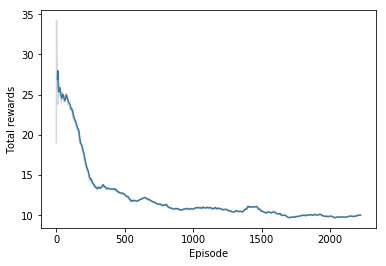

In [233]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

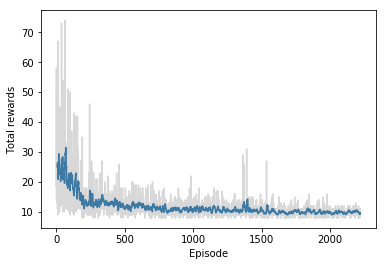

In [234]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

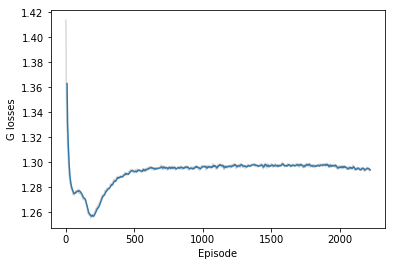

In [235]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0, 0.5, 'D losses')

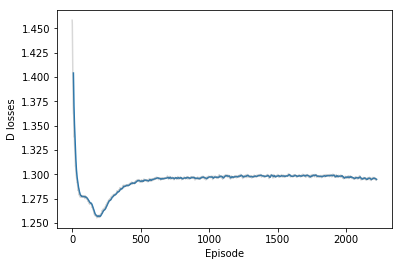

In [236]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.